# Simulation Comparisons

This notebook introduces how this prokect compares the different methods using simulations.

## Overview

A key question for interpreting prior work is to consider how the different employed methods relate to each other. To investigate this, this project uses simulated data and applies different methods to compare their results.

In this section, the main question is the evaluate the relationship between different methods across parameters variations, to evaluate which methods are highly correlated (suggesting they reflect the same properties in the data), and which appear to be more independent (suggesting they reflect different properties in the data).

Note that due to large number of possible comparisons across different methods and different simulated parameters, in this section we necessarily restrict the comparison to a selected subset of methods, that are compared pairwise. 

In [1]:
import numpy as np

from fooof.plts import plot_spectra

from neurodsp.spectral import compute_spectrum
from neurodsp.spectral.utils import trim_spectrum
from neurodsp.sim import sim_powerlaw, sim_combined
from neurodsp.utils import create_times, set_random_seed
from neurodsp.plts.combined import plot_timeseries_and_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_26107/680240959.py:3: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.plts import plot_spectra


In [2]:
# Import the `run_comparisons` function from the custom code folder
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_comparisons
from apm.analysis import compute_all_corrs
from apm.plts import plot_dots
from apm.plts.settings import EXT, COLORS
from apm.sim.sim import sig_sampler
from apm.sim.update import create_updater, create_sampler, param_sampler
from apm.sim.defs import SIM_SAMPLERS

## Settings

In [3]:
# Set random seed
set_random_seed(111)

In [4]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '14_sim_comps'

In [5]:
# Set plot style
import seaborn as sns
sns.set_context('talk')

## Simulations

In this section, we will use simulated data to compare methods. 

In [6]:
# Create a times vector for time series
times = create_times(**SIM_SAMPLERS.base)

In [7]:
# Define general settings for creating simulations
N_SIMS = 3
RETURN_PARAMS = True

### Sample Simulations

In [8]:
# Define ranges to sample parameters from
samplers_ap = {
    create_updater('exponent') : create_sampler(np.round(np.arange(-2.5, 0.1, 0.1), 1)),
}

In [9]:
# Define a parameter sampler
sampler = param_sampler(SIM_SAMPLERS.params['ap'], samplers_ap, N_SIMS)

In [10]:
# Check example sampled parameters
for params in sampler:
    print(params)

{'n_seconds': 30, 'fs': 250, 'exponent': -0.5, 'f_range': (0.5, None)}
{'n_seconds': 30, 'fs': 250, 'exponent': -1.3, 'f_range': (0.5, None)}
{'n_seconds': 30, 'fs': 250, 'exponent': -0.5, 'f_range': (0.5, None)}


#### Example signals - aperiodic

In [11]:
# Initialize signal generator for aperiodic signals
sig_gen_ap = sig_sampler(sim_powerlaw, sampler, RETURN_PARAMS)

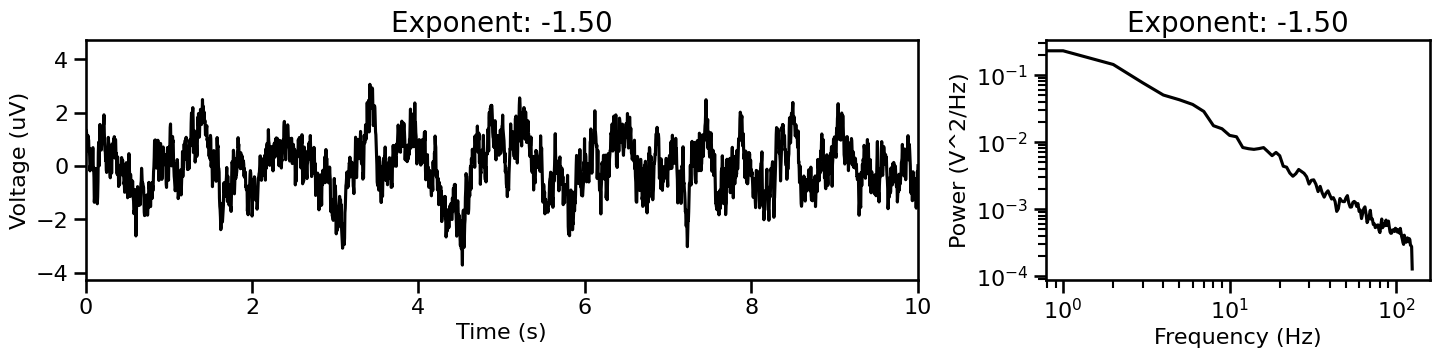

In [12]:
# Plot example generated signals
for cur_sig_ap, cur_params_ap in sig_gen_ap:
    plot_timeseries_and_spectra(cur_sig_ap, SIM_SAMPLERS.fs, ts_range=[0, 10],
                                title=str('Exponent: {:1.2f}'.format(cur_params_ap['exponent'])))

### SimSamplers

In [13]:
# Check pre-defined samplers available in imported object
SIM_SAMPLERS.labels

['comb_sampler']

In [14]:
# Reset number of samples
SIM_SAMPLERS.n_samples = 3

#### Example signals - combined

In [15]:
# Initialize signal generator for aperiodic signals
sig_gen_comb = sig_sampler(sim_combined, SIM_SAMPLERS['comb_sampler'], RETURN_PARAMS)

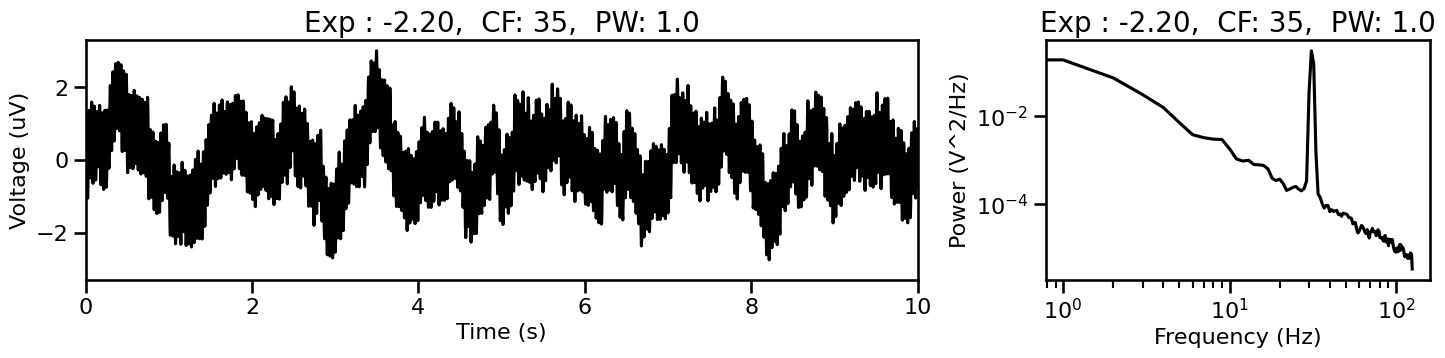

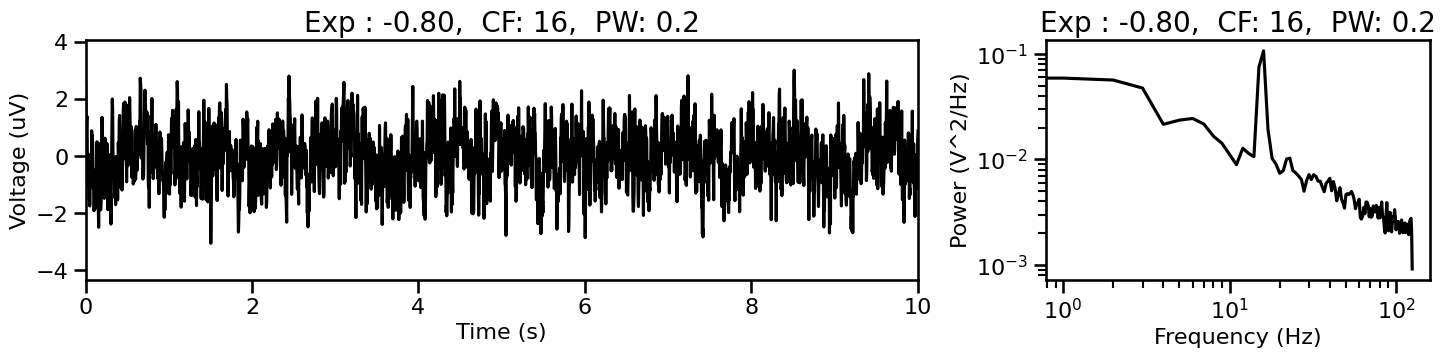

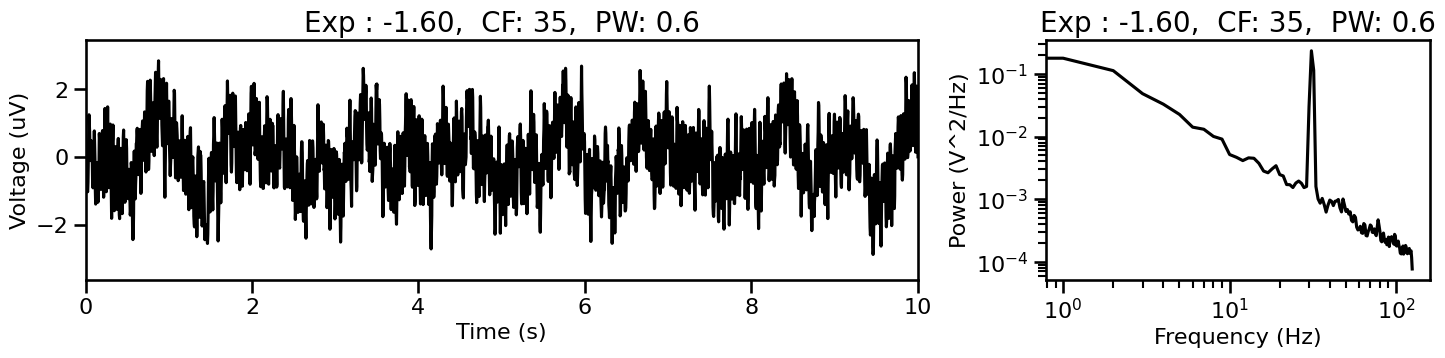

In [16]:
# Plot example generated signals
for cur_sig_comb, cur_params_comb in sig_gen_comb:
    plot_timeseries_and_spectra(cur_sig_comb, SIM_SAMPLERS.fs, ts_range=[0, 10],
                                title='Exp : {:1.2f},  CF: {:2.0f},  PW: {:1.1f}'.format(\
                                    cur_params_comb['components']['sim_powerlaw']['exponent'], 
                                    cur_params_comb['components']['sim_oscillation']['freq'], 
                                    cur_params_comb['component_variances'][1]))

### Plot Example Power Spectra

Here we compute and plot power spectra of example sampled simulations.

In [17]:
# Reinitialize signal generator for aperiodic signals
sig_gen_comb = sig_sampler(sim_combined, SIM_SAMPLERS['comb_sampler'], RETURN_PARAMS)

In [18]:
# Compute and collect power spectra of some sampled simulations
psds = []
for tsig, _ in sig_gen_comb:
    freqs, psd = trim_spectrum(*compute_spectrum(tsig, fs=SIM_SAMPLERS.fs, nperseg=500), [3, 50])
    psds.append(psd)

In [19]:
# Plot the collection of computed power spectra of the simulations
plot_spectra(freqs, psds, log_freqs=True, log_powers=True, colors='black', alpha=0.5,
             save_fig=SAVE_FIG, file_name='psds' + EXT, file_path=FIGPATH)

## Code Approach: `run_comparisons`

Here, we will briefly introduce the general strategy and code used to run the method comparisons on simulations. 

The overarching function used to run simulation comparisons is the `run_comparisons` function.

This approach allows for:
- defining a procedure to simulate time series
- defining a set of measures to apply to the simulated time series
- applying the set of measures across simulated instances, sampling from parameter ranges

In [20]:
# Check the documentation for `run_comparisons`
print(run_comparisons.__doc__)

Compute multiple measures of interest across the same set of simulations.

    Parameters
    ----------
    sim_func : callable
        A function to create simulated time series.
    sim_params : iterable or list of dict
        Simulation parameters for `sim_func`.
    measures : dict
        Functions to apply to the simulated data.
        The keys should be functions to apply to the data.
        The values should be a dictionary of parameters to use for the method.
    n_sims : int, optional
        The number of simulations to run.
    return_params : bool, default: False
        Whether to collect and return the parameters of all the generated simulations.
    verbose : bool, optional, default: False
        Whether to print out simulation parameters.
        Used for checking simulations / debugging.

    Returns
    -------
    results : dict
        Computed results for each measure across the set of simulated data.
    all_sim_params : pd.DataFrame
        Collected simula

Next, we can run an example of using `run_comparisons`.

To do so, we will define an example analysis to apply some measures of interest (here, computing the mean and the variance) across samples of simulations of powerlaw data.

In [21]:
# Define the measures to apply to the simulated signals
measures = {np.var : {}, np.mean : {}}

#### Run simulations across variations in exponent

In [22]:
# Run comparisons across samples of aperiodic noise
results1, all_sim_params1 = run_comparisons(\
    sim_powerlaw, SIM_SAMPLERS['comb_sampler'], measures, return_params=True, verbose=True) 

{'n_seconds': 30, 'fs': 250, 'components': {'sim_powerlaw': {'exponent': -0.3, 'f_range': (0.5, None)}, 'sim_oscillation': {'freq': 8}}, 'component_variances': [1, 0.0]}
{'n_seconds': 30, 'fs': 250, 'components': {'sim_powerlaw': {'exponent': -2.0, 'f_range': (0.5, None)}, 'sim_oscillation': {'freq': 32}}, 'component_variances': [1, 0.8]}
{'n_seconds': 30, 'fs': 250, 'components': {'sim_powerlaw': {'exponent': -1.8, 'f_range': (0.5, None)}, 'sim_oscillation': {'freq': 16}}, 'component_variances': [1, 0.7]}


In [23]:
# Check output simulation parameters
all_sim_params1

n_seconds   fs  exponent      f_range  freq  var_ap  var_pe  has_osc
0         30  250      -0.3  (0.5, None)     8       1     0.0    False
1         30  250      -2.0  (0.5, None)    32       1     0.8     True
2         30  250      -1.8  (0.5, None)    16       1     0.7     True

In [24]:
# Check output values of computed measures
results1

{'var': array([1., 1., 1.]),
 'mean': array([4.54747351e-17, 0.00000000e+00, 1.51582450e-17])}

In [25]:
# Compute the correlations between output measures
compute_all_corrs(results1)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


{'var': {'mean': (nan, nan, (nan, nan))},
 'mean': {'var': (nan, nan, (nan, nan))}}

#### Run simulations across variations in multiple parameters

In [26]:
SIM_SAMPLERS.n_samples = None

In [27]:
# Run comparisons across samples of aperiodic noise
results2, all_sim_params2 = run_comparisons(\
    sim_combined, SIM_SAMPLERS['comb_sampler'], measures, n_sims=25, return_params=True) 

In [28]:
# Check output simulation parameters
all_sim_params2.head(5)

n_seconds   fs  exponent      f_range  freq  var_ap  var_pe  has_osc
0         30  250      -1.0  (0.5, None)    26       1     0.8     True
1         30  250      -0.8  (0.5, None)    25       1     0.3     True
2         30  250      -1.0  (0.5, None)    28       1     0.1     True
3         30  250      -1.0  (0.5, None)     6       1     0.1     True
4         30  250      -0.3  (0.5, None)    24       1     0.0    False

In [29]:
# Check output values of computed measures
results2

{'var': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]),
 'mean': array([-7.10542736e-18, -1.37371596e-17,  1.89478063e-18,  9.47390314e-18,
        -3.07901852e-18, -3.78956126e-18,  7.57912251e-18, -6.86857978e-18,
        -1.51582450e-17,  9.82917451e-18, -4.73695157e-19, -6.15803704e-18,
        -1.89478063e-18, -3.78956126e-18, -1.32634644e-17,  4.73695157e-18,
        -1.42108547e-17, -1.14278957e-17, -9.47390314e-19, -1.98951966e-17,
         2.84217094e-18,  1.51582450e-17, -3.31586610e-18, -1.12502600e-17,
         5.68434189e-18])}

In [30]:
# Compute the correlations between output measures
compute_all_corrs(results2)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


{'var': {'mean': (0.2842002305334353, 0.16856237464334226, (nan, nan))},
 'mean': {'var': (0.2842002305334353, 0.16856237464334226, (nan, nan))}}

### Evaluating Results

After computing the measures, we can examine the results, comparing between different measurements.

In [31]:
# Collect colors for each value based on presence of an oscillation
colors = [COLORS['CM'] if osc else COLORS['AP'] for osc in all_sim_params2.has_osc]

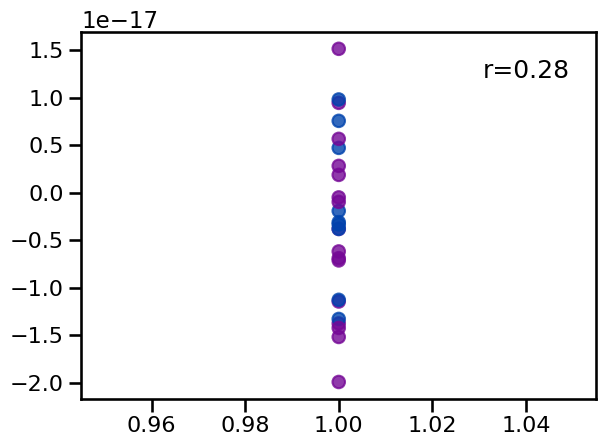

In [32]:
# Plot the computed measures against each other
plot_dots(results2['var'], results2['mean'], c=colors, alpha=0.8)